<a href="https://colab.research.google.com/github/StefanHubner/MachineLearningEconomics/blob/main/Logit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("ISLR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [24]:
library(ISLR)

data("Default")
Default$default1 <- as.double(Default$default == "Yes")

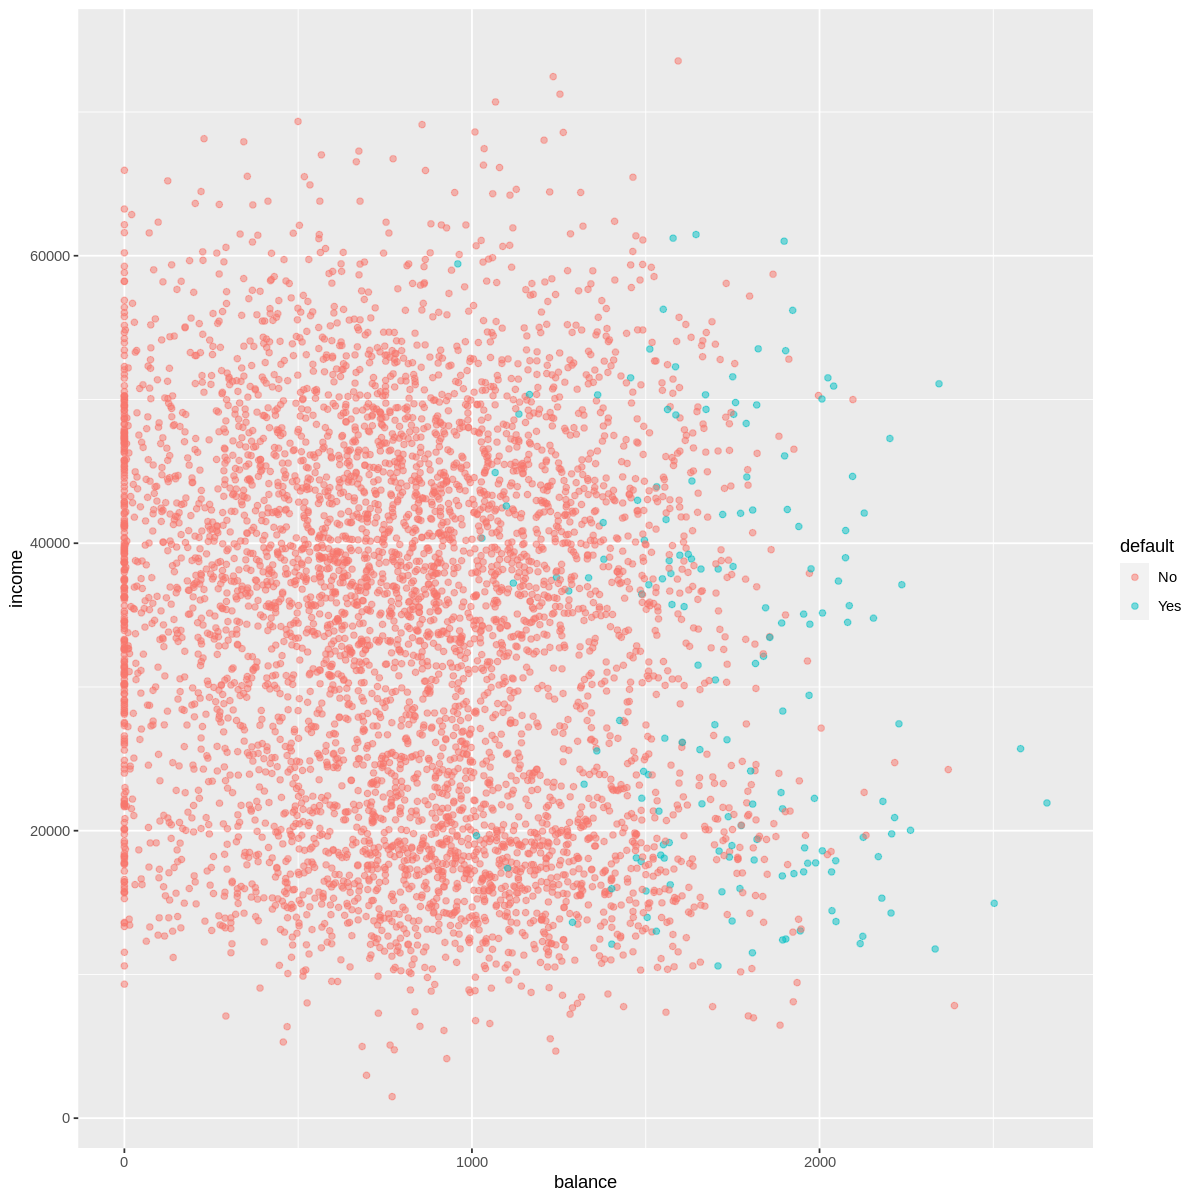

In [75]:
library(ggplot2)

options(repr.plot.width = 10, repr.plot.height = 10)

n <- nrow(Default)
traini <- sample(1:n, n/2)
testi <- -traini

p0 <- ggplot(Default[testi,], aes(y = income, x = balance, color = default)) +
        geom_point(alpha = 0.5)

p0

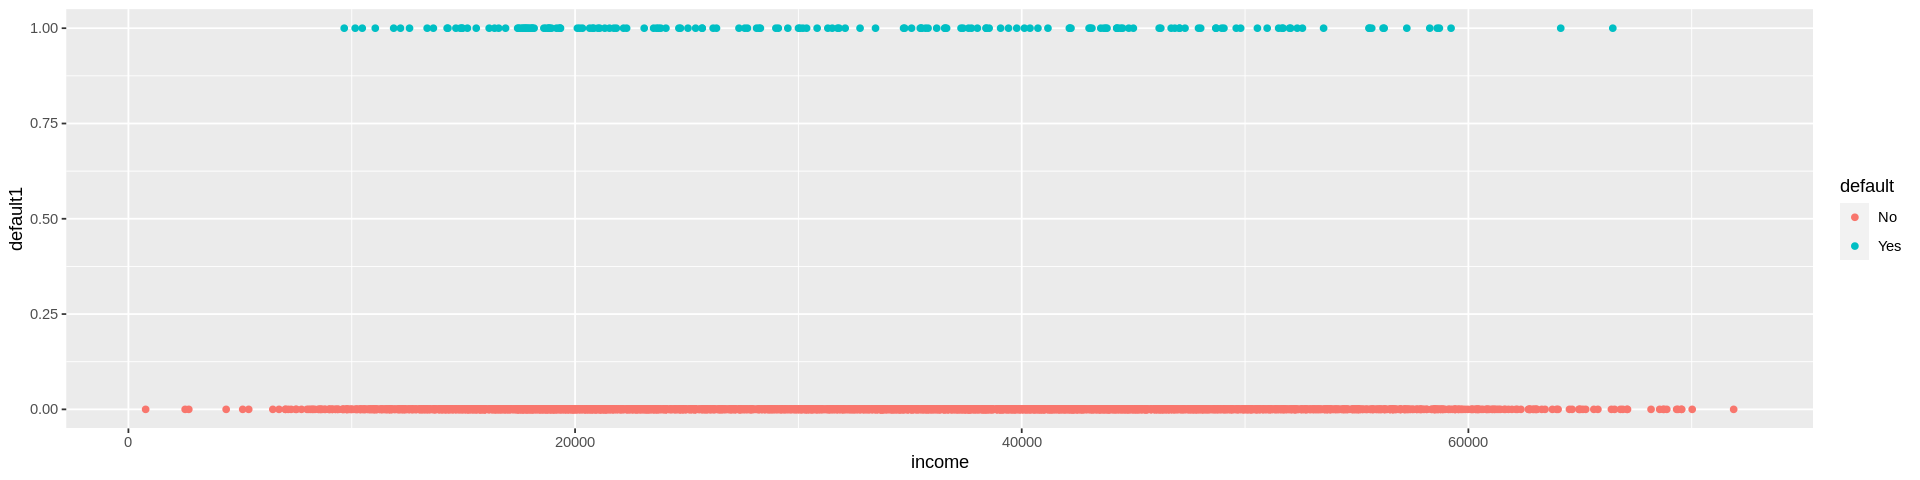

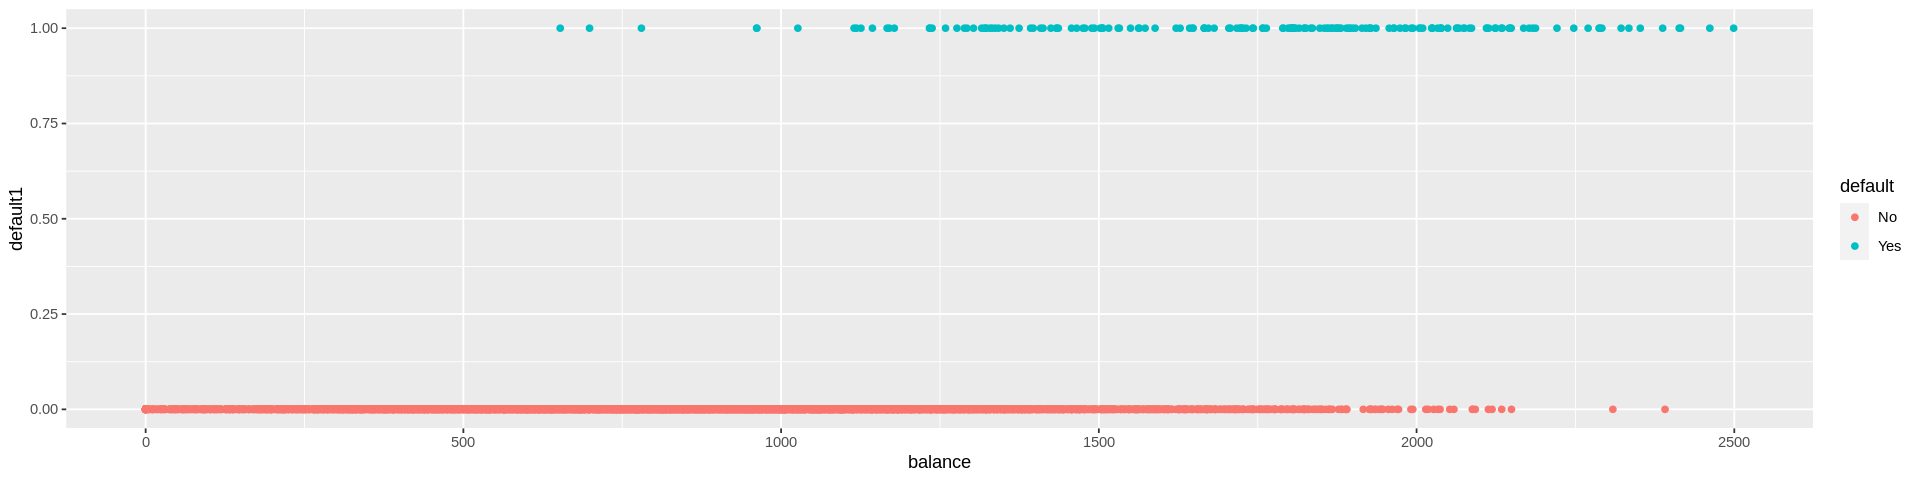

In [76]:
options(repr.plot.width = 16, repr.plot.height = 4)

p1 <- ggplot(Default[traini,], aes(y = default1, x = income, color = default)) +
        geom_point()

p2 <- ggplot(Default[traini,], aes(y = default1, x = balance, color = default)) +
        geom_point()

p1
p2


Estimated parameters: ( -10.1184535949863, 0.00517037286016893 )
Neg. log-likelihood:  425.5088 


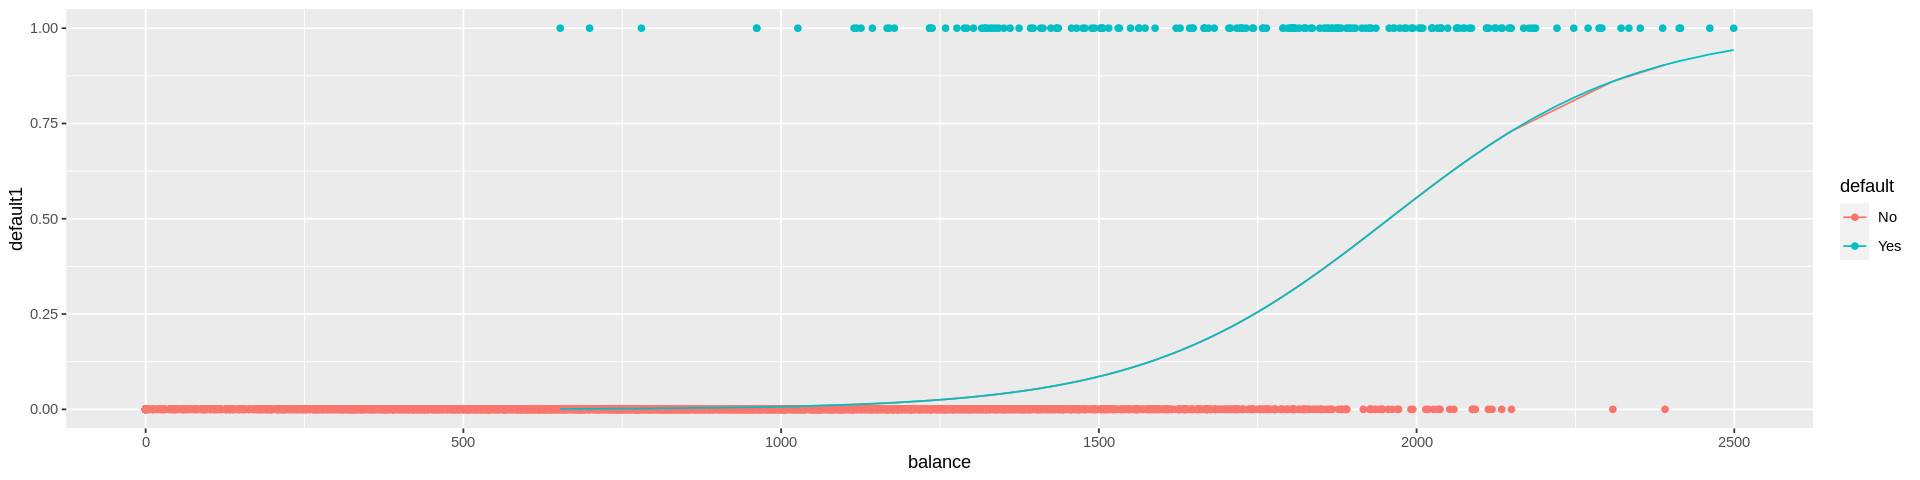

In [77]:
# Define the log-likelihood function for a binary choice model with logistic errors
build_ll <- function(y, x) {
  function(beta) {
    p_hat <- plogis(cbind(1, x) %*% beta)
    -sum(y * log(p_hat) + (1 - y) * log(1 - p_hat))
  }
}

train <- Default[traini,]

# Estimate the model parameters using optim
start <- c(0, 0) # Initial guesses for the parameters
result <- optim(start, build_ll(train$default1, train$balance))

# Print the estimated parameters
cat("Estimated parameters: (", paste0(result$par, collapse = ", "), ")\n")
cat("Neg. log-likelihood: ", result$value, "\n")

yhat <- plogis(cbind(1, train$balance) %*% result$par)
p2 + geom_line(aes(y = yhat, x = balance))

In [79]:
x1x2 <- as.matrix(train[,c("balance", "income")])

start <- c(0, 0, 0) # Initial guesses for the parameters
result <- optim(start, build_ll(train$default1, x1x2))
b <- result$par

# Print the estimated parameters
cat("Estimated parameters: (", paste0(b, collapse = ", "), ")\n")
cat("Neg. log-likelihood: ", result$value, "\n")

yhat <- plogis(cbind(1, x1x2) %*% b)

Estimated parameters: ( -11.2683569024099, 0.00536305006727622, 2.71937994583411e-05 )
Neg. log-likelihood:  417.7503 



Now that we have two predictors $x_1$ and $x_2$ for a logistic regression, the logistic function looks like:

$$ P(Y=1 | x_1, x_2) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2})} $$

Here, the decision boundary will be the set of points $(x_1, x_2)$ for which $ P(Y=1 | x_1, x_2) = 0.5 $.

To find this boundary, you can set:

$$ \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2})} = 0.5 $$

Solving for this, you get:

$$ e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2)} = 1 $$

Taking the natural logarithm on both sides (although it's unnecessary since the exponent term equals 1), and rearranging for $x_2$, you get:

$$ x_2 = -\frac{\beta_0}{\beta_2} -\frac{\beta_1}{\beta_2} x_1 $$

This equation represents a line in the $x_1, x_2$ plane. All points on this line correspond to a probability of 0.5. Points above this line will have $ P(Y=1 | x_1, x_2) > 0.5 $ and points below this line will have $ P(Y=1 | x_1, x_2) < 0.5 $.

This linear equation is the Bayes decision boundary (BDB) in the context of a logistic regression model with two predictors.

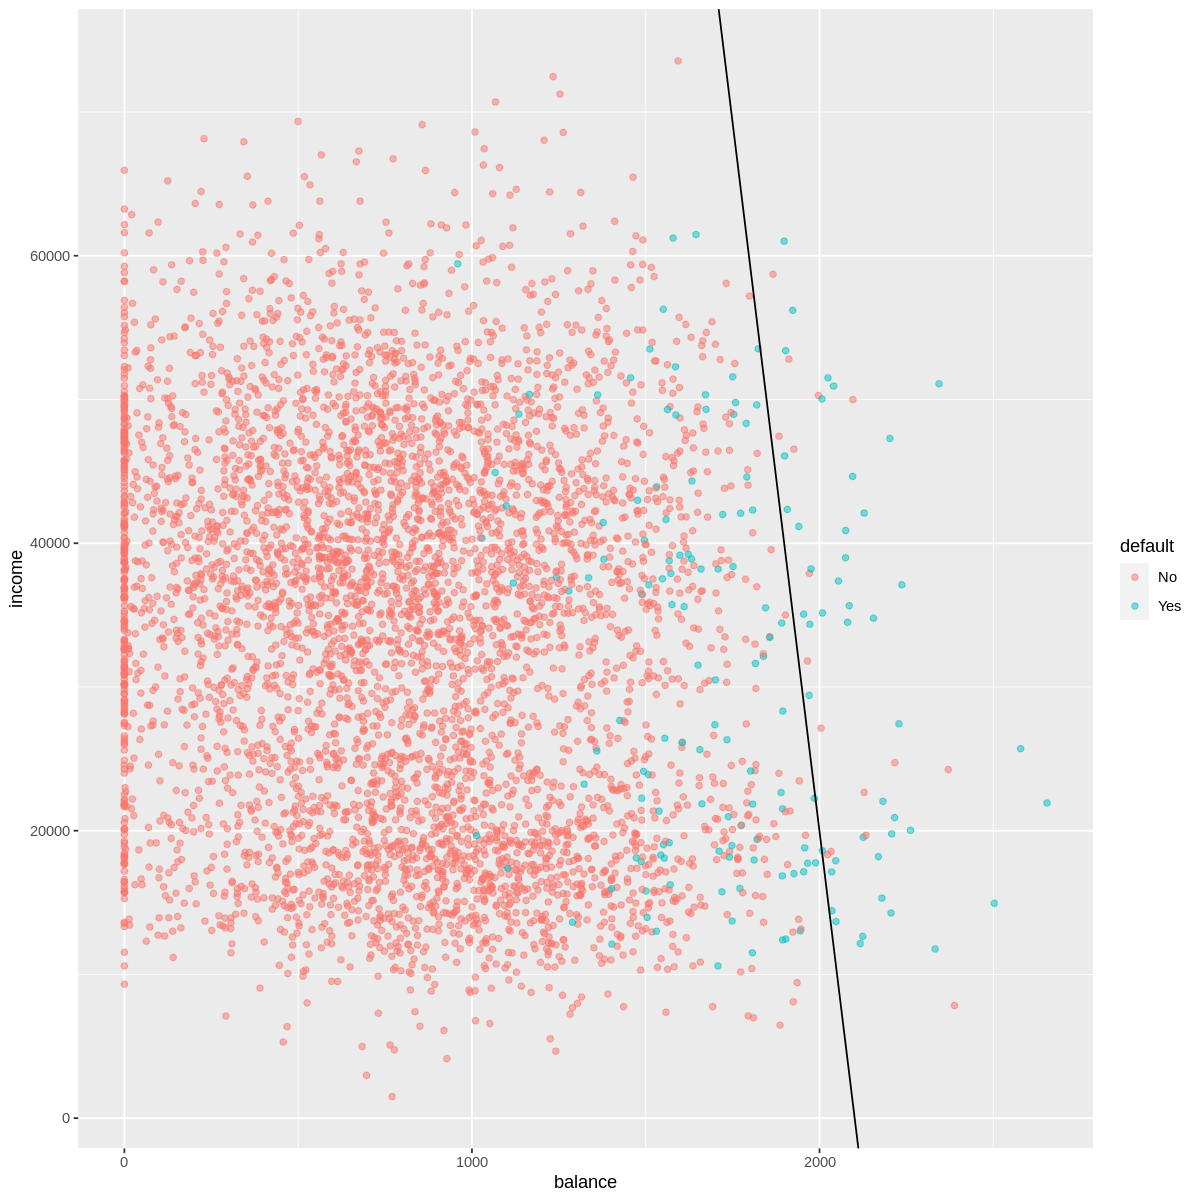

In [80]:
options(repr.plot.width = 10, repr.plot.height = 10)
p0 + geom_abline(intercept = -b[1]/b[3], slope = -b[2]/b[3])

## Interpretation
- red on the rhs (above the BDB): false positives - we predicted them to default, but they didn't
- blue on the lhs (below the BDB): false negatives - we didn't predict them to default, but they did